<a href="https://colab.research.google.com/github/PeterJackson61/RNSA_2017/blob/main/RNSA_2017_Pneumonia_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"winsonnguyen","key":"3201b1729ad34de122cc0fff4d03090f"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge


100% 3.66G/3.66G [02:52<00:00, 21.5MB/s]
100% 3.66G/3.66G [02:52<00:00, 22.8MB/s]


In [4]:
!unzip rsna-pneumonia-detection-challenge.zip -d /content/RNSA_2017

Streaming output truncated to the last 5000 lines.
  inflating: /content/RNSA_2017/stage_2_train_images/d5231546-354e-4071-9af1-6644beabfd86.dcm  
  inflating: /content/RNSA_2017/stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: /content/RNSA_2017/stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: /content/RNSA_2017/stage_2_train_images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: /content/RNSA_2017/stage_2_train_images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: /content/RNSA_2017/stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: /content/RNSA_2017/stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: /content/RNSA_2017/stage_2_train_images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: /content/RNSA_2017/stage_2_train_images/d52ce67b-be7c-4349-8dc4-38562928d208.dcm  
  inflating: /content/RNSA_2017/stage_2_train_images/d535a3c8-c4a4-4856-b5cd-17f6332e

In [5]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 34.9 MB/s 


In [6]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [8]:
labels = pd.read_csv('./RNSA_2017/stage_2_train_labels.csv')

In [9]:
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [10]:
len(labels) - len(labels['patientId'].unique())

3543

In [16]:
labels = labels.drop_duplicates("patientId")

In [11]:
ROOT_PATH = Path("RNSA_2017/stage_2_train_images")
SAVE_PATH = Path("RNSA_2017/Processed")

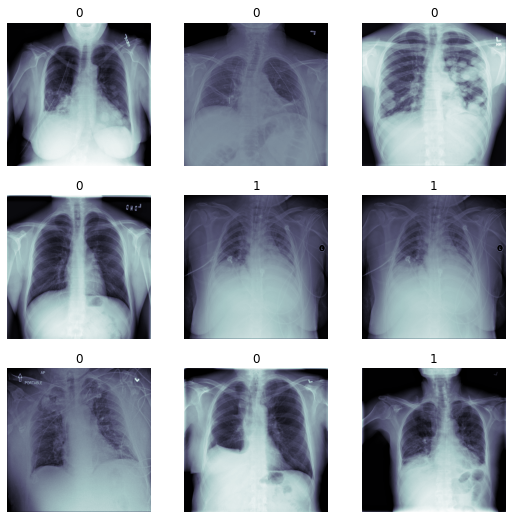

In [12]:
fig, axis = plt.subplots(3,3, figsize=(9,9))
c=0
for i in range(3):
  for j in range(3):
    patient_id = labels.patientId.iloc[c]
    dcm_path = ROOT_PATH/patient_id
    dcm_path = dcm_path.with_suffix(".dcm")
    dcm = pydicom.read_file(dcm_path).pixel_array

    label = labels["Target"].iloc[c]

    axis[i][j].imshow(dcm, cmap='bone')
    axis[i][j].set_title(label)
    axis[i][j].axis('off')
    c+=1


### Split the train data to train and validation data

In [13]:
sums, sums_squared = 0,0

for c, patient_id in enumerate(tqdm(labels.patientId)):
  patient_id = labels.patientId.iloc[c]
  dcm_path = ROOT_PATH/patient_id
  dcm_path = dcm_path.with_suffix(".dcm")
  dcm = pydicom.read_file(dcm_path).pixel_array / 255

  dcm_array = cv2.resize(dcm, (224,224)).astype(np.float16)

  label = labels.Target.iloc[c]

  train_or_val = "train" if c<24000 else "val"
  current_save_path = SAVE_PATH/train_or_val/str(label)
  current_save_path.mkdir(parents=True, exist_ok=True)
  np.save(current_save_path/patient_id, dcm_array)

  normalizer = 224*224
  if train_or_val == "train":
    sums += np.sum(dcm_array)/normalizer
    sums_squared += (dcm_array**2).sum() / normalizer

  0%|          | 0/30227 [00:00<?, ?it/s]

In [14]:
mean = sums / 24000
std = np.sqrt((sums_squared / 24000) - mean**2)

In [15]:
mean, std

(0.4889087844122021, 0.24617960640014458)

In [16]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 34.2 MB/s 


In [17]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 800 kB 32.1 MB/s 
     |████████████████████████████████| 125 kB 78.5 MB/s 


In [18]:
from torchvision import transforms
import torchmetrics 
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import torchvision

In [19]:
def load_file(path):
  return np.load(path).astype(np.float32)

In [20]:
train_transfrom = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49,0.248),
    transforms.RandomAffine(degrees = (-5,5), translate=(0, 0.05), scale=(0.9,1.1)),
    transforms.RandomResizedCrop((224,224), scale=(0.35, 1))
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49,0.248),
])

In [21]:
train_dataset = torchvision.datasets.DatasetFolder("RNSA_2017/Processed/train/",
                                                  loader = load_file,
                                                  extensions = "npy",
                                                  transform = train_transfrom)
val_dataset = torchvision.datasets.DatasetFolder("RNSA_2017/Processed/val/",
                                                  loader = load_file,
                                                  extensions = "npy",
                                                  transform = train_transfrom)

In [32]:
train_dataset[0]

(tensor([[[-1.9284, -1.9366, -1.9442,  ..., -1.0781, -1.0932, -1.1085],
          [-1.9284, -1.9366, -1.9442,  ..., -1.0719, -1.0788, -1.0814],
          [-1.9284, -1.9366, -1.9442,  ..., -1.0613, -1.0588, -1.0502],
          ...,
          [-1.9442, -1.9377, -1.9342,  ...,  1.6426,  1.6419,  1.6456],
          [-1.9442, -1.9403, -1.9382,  ...,  1.6444,  1.6448,  1.6501],
          [-1.9442, -1.9442, -1.9442,  ...,  1.6547,  1.6507,  1.6548]]]), 0)

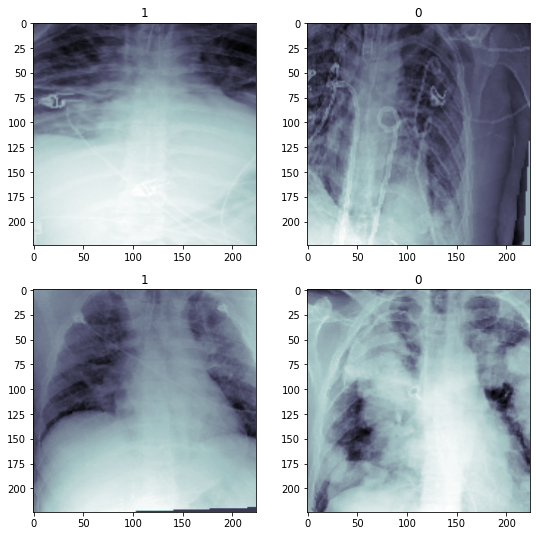

In [23]:
fig, axis = plt.subplots(2,2, figsize = (9,9))
for i in range(2):
  for j in range(2):
    random_index = np.random.randint(0, 24000)
    x_ray, label = train_dataset[random_index]
    axis[i][j].imshow(x_ray[0], cmap = "bone")
    axis[i][j].set_title(label)

In [25]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import torch

In [31]:
torch.__version__

'1.13.0+cu116'

In [33]:
batch_size = 64
num_workers = 4

train_loadar = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = batch_size,
                                           num_workers = num_workers,
                                           shuffle = True
                                           )
val_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = batch_size,
                                           num_workers = num_workers,
                                           shuffle = True
                                           )

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Checking the unbalanc of the data

In [35]:
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([16008,  4985]))

### Inspect a model

In [36]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
class PneumoniaModel(pl.LightningModule):

  def __init__(self):
    self.model = torchvision.models.resnet18()
    self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    self.model.fc = torch.nn.Linear(in_features=512, out_features=1000, bias=True)
    self.optimizer = torch.optim.Adam(self)